# EDA & Feature Engineering

# Library and data import

In [24]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from metpy.units import units
from metpy.calc import relative_humidity_from_dewpoint
import datetime

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 25)

In [25]:
# import train_cleaned clean
train_cleaned = pd.read_csv("../output_data/train_clean.csv")

# import weather clean
weather_cleaned = pd.read_csv("../output_data/weather_clean.csv")

# import spray clean
spray_cleaned = pd.read_csv("../output_data/spray_clean.csv")

# train_cleaned

### Mosquito Species 

The ability of different mosquito species to acquire and transmit WNV is highly variable. Culex mosquitoes are accepted as the dominant global transmission vector of WNV to humans; but their transmission rates among various species of the Culex genus may vary widely. As a result, it will be worth investigating which Culex mosquito species is the most dominant vector.



According to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3485754/, Culex Tarsalis is the main mosquito vector of WNV in the USA, and is capable of injecting the virus into a variety of mammalian and avian hosts. Culex pipiens, Culex restuans, and Culex Salinarius are also widely viewed as important mosquito vectors by the scientific community.


In fact, scientists view the mosquito species as a more important variable influencing WNV transmission compared to any other factor (eg. climate and weather). As a result, correct engineering of this feature is extremely pivotal.

## Mosquito Species: Feature Engineering & Encoding

In [26]:
train_cleaned.head()

,Date,Species,Trap,AddressNumberAndStreet,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,PIPIENS/RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,1,0
1,2007-05-29,RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,1,0
2,2007-05-29,RESTUANS,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,1,0
3,2007-05-29,PIPIENS/RESTUANS,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,1,0
4,2007-05-29,RESTUANS,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,4,0


Plotting a bar chart of frequency of WNV found per mosquito species.

/Users/JunnYiow/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


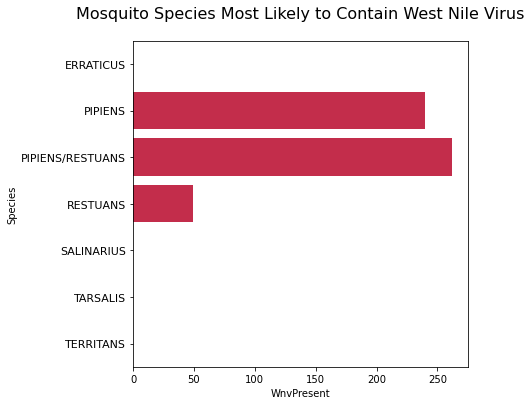

In [27]:
mosquitoes = train_cleaned[["Species", "NumMosquitos", "WnvPresent"]].groupby(by = "Species").sum().reset_index()
plt.figure(figsize = (6,6))
sns.barplot(mosquitoes["WnvPresent"], mosquitoes["Species"], color = "crimson")
plt.title("Mosquito Species Most Likely to Contain West Nile Virus", fontsize = 16, y = 1.05)
plt.yticks(fontsize = 11)
plt.show()

This dataframe shows the total number of each species present, as well as amount of species infected with WNV.

In [28]:
mosquitoes = train_cleaned[["Species", "NumMosquitos", "WnvPresent"]].groupby(by = "Species").sum()
mosquitoes

,NumMosquitos,WnvPresent
Species,,
ERRATICUS,7,0
PIPIENS,44671,240
PIPIENS/RESTUANS,66268,262
RESTUANS,23431,49
SALINARIUS,145,0
TARSALIS,7,0
TERRITANS,510,0


Attempt to normalize mosquito species data by finding the proportion of mosquitoes found that contain the WNV, and using ordinal encoding to rank them based on importance.

In [29]:
mosquitoes["percentage"] = mosquitoes["WnvPresent"] / mosquitoes["NumMosquitos"]
mosquitoes["percentage"]

Species
ERRATICUS           0.000000
PIPIENS             0.005373
PIPIENS/RESTUANS    0.003954
RESTUANS            0.002091
SALINARIUS          0.000000
TARSALIS            0.000000
TERRITANS           0.000000
Name: percentage, dtype: float64

Ordinal Encoding of the Mosquito variable based on probability of finding WNV in them.

In [30]:
# train_cleaned["Species"] = train_cleaned["Species"].map({"CULEX ERRATICUS": 0, "CULEX SALINARIUS": 0, "CULEX TARSALIS": 0, "CULEX TERRITANS": 0,
#                                         "CULEX RESTUANS": 1, "CULEX PIPIENS/RESTUANS": 2, "CULEX PIPIENS": 3})

The final engineered feature shows a correlation of 0.122 with the target. Spearman is used because it is a non-parametric measure of correlation, and nothing can be assumed of the underlying mosquito distribution without further analysis (which is out of the scope of this). Pearson would assume that the underlying distribution of mosquitoes follows a Gaussian distribution.

In [31]:
train_cleaned["Species"].corr(train_cleaned["WnvPresent"], method = "spearman")

-0.12177864844087631

# Weather

Research on NCBI suggests that weather is an extremely important factor influencing the mosquito lifecycle, with infection and dissemination rates positively correlating with temperatures (especially above 25 degrees).

The most important weather factors:
- Average temperature
- Relative humidity
- Rainfall/precipitation rates
- Temperature fluctuation
- Light intensity


The Koppen weather classification classifies Chicago as a hot summer humid continental.

Most laboratory mosquito research appears to elucidate the relationship between a static temperature and mosquito vector growth rate/ WNV transmission rates. However, in reality, temperature is not perfectly controlled, and instead follows a stochastic pattern. There is insufficient data displaying the effect of a fluctuating or dynamic temperature system on WNV replication and transmission rates.

Instead, data regarding temperature fluctuation can be found about a closely related virus in the flavivirus family, Zika. As a result, a variable measuring the fluctuation of temperature would be engineered. As climate change intensifies, the importance of this variable will heighten.

In [32]:
weather_cleaned["temp_fluct"] = weather_cleaned["tmax"] - weather_cleaned["tmin"]

Research on NCBI shows that light intensity is also a critical factor to look at. The steps below show data preparation before engineering of the "Light Intensity" variable, operationalized by sunset - sunrise. Although this variable shows colinearity with average temperature, laboratory mosquito research has successfully isolated the two, and proven that light intensity alone (independent of temperature increase) would increase important biological steps in the WNV transmission process.

In [33]:
weather_cleaned.dtypes

station          int64
date            object
tmax             int64
tmin             int64
tavg           float64
depart         float64
dewpoint         int64
wetbulb        float64
heat           float64
cool           float64
sunrise         object
sunset          object
preciptotal    float64
stnpressure    float64
sealevel       float64
resultspeed    float64
resultdir        int64
avgspeed       float64
temp_fluct       int64
dtype: object

In [34]:
weather_cleaned['date'] = pd.to_datetime(weather_cleaned['date'])

In [35]:
weather_cleaned['year'] = weather_cleaned['date'].dt.year

In [36]:
weather_cleaned['mth_day'] = weather_cleaned['date'].dt.strftime("%m-%d")

In [22]:
weather_cleaned['week'] = weather_cleaned['date'].dt.isocalendar().week.astype(int)

In [23]:
#new feature - daylight
weather_cleaned['daylight'] = (weather_cleaned['sunset'].astype('datetime64') - 
                       weather_cleaned['sunrise'].astype('datetime64')).dt.seconds/3600

In [24]:
def cal_rh(temp, dewpoint):
    rh = relative_humidity_from_dewpoint(temperature= temp * units.fahrenheit, 
                                         dewpoint= dewpoint * units.fahrenheit).magnitude
    return rh

In [25]:
weather_cleaned['relative_hum'] = weather_cleaned.apply(lambda x: cal_rh(x['tavg'], x['dewpoint']), axis =1)

In [26]:
weather_cleaned.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,temp_fluct,year,mth_day,week,daylight,relative_hum
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,04:48,18:49,0.0,29.10,29.82,1.7,27,9.2,33,2007,05-01,18,14.016667,0.564102
1,2,2007-05-01,84,52,68.0,14.0,51,57.0,0.0,3.0,04:48,18:49,0.0,29.18,29.82,2.7,25,9.6,32,2007,05-01,18,14.016667,0.544973
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,04:47,18:50,0.0,29.38,30.09,13.0,4,13.4,17,2007,05-02,18,14.050000,0.711769
3,2,2007-05-02,60,43,52.0,-3.0,42,47.0,13.0,0.0,04:47,18:50,0.0,29.44,30.08,13.3,2,13.4,17,2007,05-02,18,14.050000,0.685947
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,04:46,18:51,0.0,29.39,30.12,11.7,7,11.9,20,2007,05-03,18,14.083333,0.548489


In [27]:
weather_cleaned.dtypes

station                  int64
date            datetime64[ns]
tmax                     int64
tmin                     int64
tavg                   float64
depart                 float64
dewpoint                 int64
wetbulb                float64
heat                   float64
cool                   float64
sunrise                 object
sunset                  object
preciptotal            float64
stnpressure            float64
sealevel               float64
resultspeed            float64
resultdir                int64
avgspeed               float64
temp_fluct               int64
year                     int64
mth_day                 object
week                     int64
daylight               float64
relative_hum           float64
dtype: object

Text(0.5, 1.0, 'Average relative humidity from May to Oct')

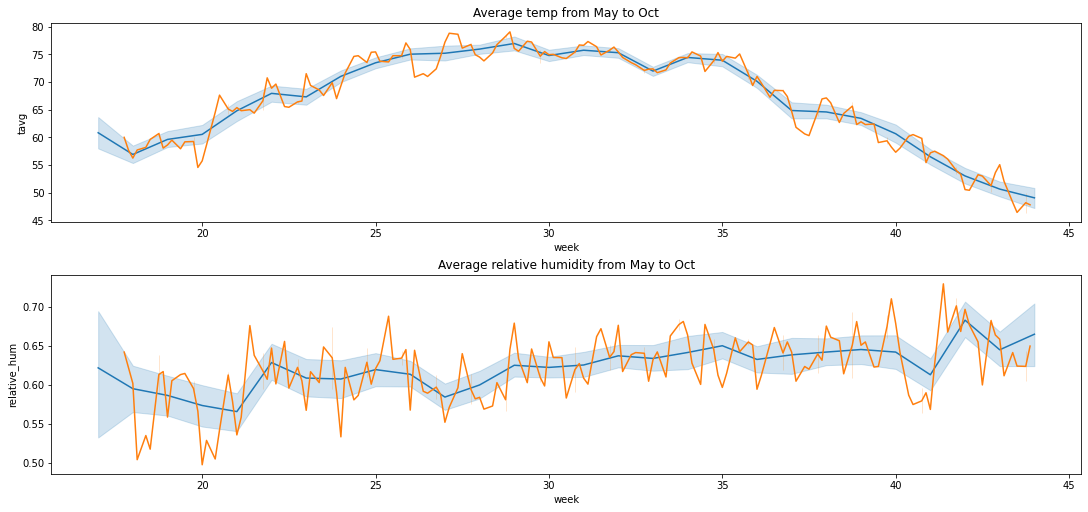

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,7), constrained_layout=True)

sns.lineplot(data=weather_cleaned, x='week', y='tavg', ax=ax[0])
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='tavg',ax=ax[0]);

sns.lineplot(data=weather_cleaned, x='week', y='relative_hum', ax=ax[1]);
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='relative_hum', ax=ax[1]);

ax[0].set_title("Average temp from May to Oct")
ax[1].set_title("Average relative humidity from May to Oct")

In [29]:
#create function for plotting
def plot_func(dataframe, attr, **kwarg):
    ''' Plot histogram, scatter plot, box plot, and qq plot in a figure.
    
    Note: 
    - For scatter plot, the attribute is plotted agaist saleprice.
    - Box plot is overlaid with strip plot to provide a sense of distribution of the data. 
    - There for categorical features, there will be no qq plot
    
    Parameters:
    data (dataframe): pandas dataframe 
    attr (list): list of dataframe column names to be plotted
    kwarg (string): accept attr: saleprice

    Returns:
    Nil'''
    row = len(attr)
    col = 3
    figsize = (20, row*4)
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=figsize, constrained_layout=True) 
    for x in range(row):
            #histogram plot
            sns.histplot(x=attr[x], data=dataframe, ax=ax[x,0], color='tab:red', )
            ax[x, 0].set_title(f'histogram: {attr[x]}')
            ax[x, 0].tick_params(labelrotation=90, axis='x')
            #scatter plot
            sns.scatterplot(x='week', y=attr[x], data=dataframe, ax=ax[x,1])
            ax[x, 1].set_title(f'scatter plot: {attr[x]}')
            ax[x, 1].tick_params(labelrotation=90, axis='x')
            #box plot
            sns.boxplot(x=attr[x], data=dataframe, ax=ax[x,2])
            sns.stripplot(x=attr[x], data=dataframe, ax=ax[x,2], alpha= 0.2)
            ax[x, 2].set_title(f'boxplot: {attr[x]}')
            ax[x, 2].tick_params(labelrotation=90, axis='x')
            
    plt.show()

In [30]:
num_features = weather_cleaned.select_dtypes(include='number').columns.to_list()
cat_features = weather_cleaned.select_dtypes(exclude='number').columns.to_list()

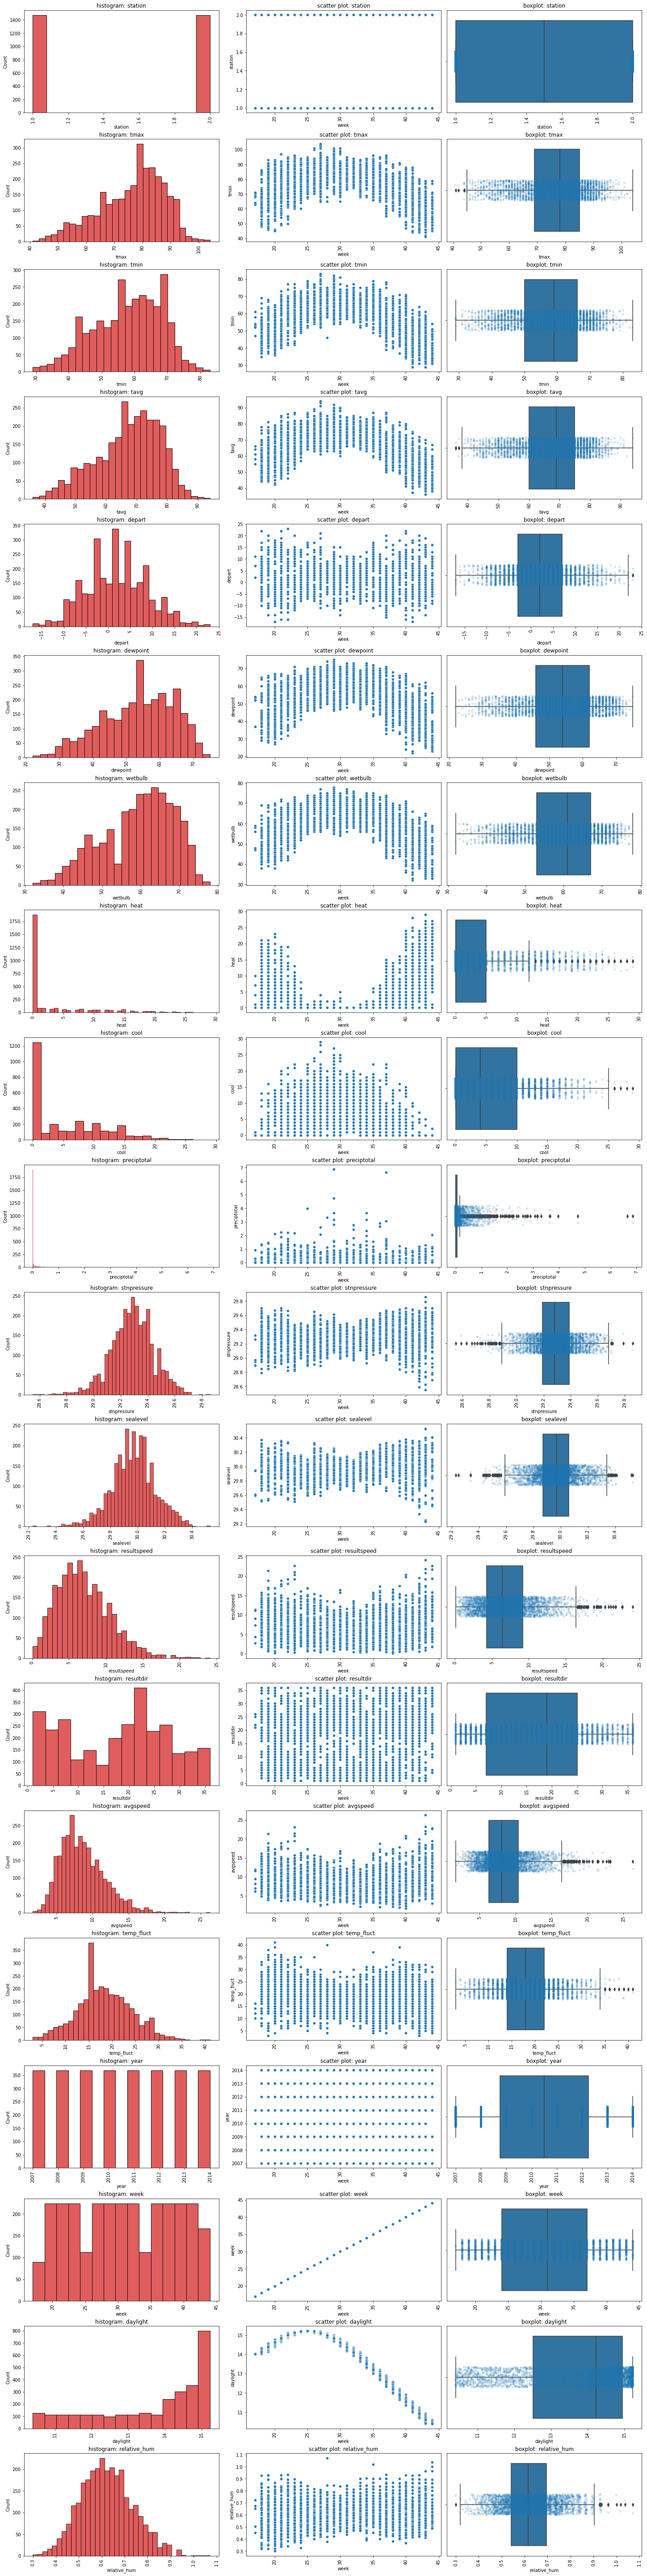

In [31]:
plot_func(weather_cleaned, num_features)